# Recommender Systems 2 - Collaborative Filtering 2

### Book Crossing Dataset
Link to dataset files: http://www2.informatik.uni-freiburg.de/~cziegler/BX/

Collected by Cai-Nicolas Ziegler in a 4-week crawl (August / September 2004) from the Book-Crossing community with kind permission from Ron Hornbaker, CTO of Humankind Systems. Contains 278,858 users (anonymized but with demographic information) providing 1,149,780 ratings (explicit / implicit) about 271,379 books.

The Book-Crossing dataset comprises 3 tables.
#### BX-Users
Contains the users. Note that user IDs (`User-ID`) have been anonymized and map to integers. Demographic data is provided (`Location`, `Age`) if available. Otherwise, these fields contain NULL-values.
#### BX-Books
Books are identified by their respective ISBN. Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given (`Book-Title`, `Book-Author`, `Year-Of-Publication`, `Publisher`), obtained from Amazon Web Services. Note that in case of several authors, only the first is provided. URLs linking to cover images are also given, appearing in three different flavours (`Image-URL-S`, `Image-URL-M`, `Image-URL-L`), i.e., small, medium, large. These URLs point to the Amazon web site.
#### BX-Book-Ratings
Contains the book rating information. Ratings (`Book-Rating`) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.

### Import libraries

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

### Load data

In [2]:
# Load books
books = pd.read_csv('data/BX-Books.csv', sep=';', error_bad_lines=False, encoding="latin-1")
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', \
                 'imageUrlS', 'imageUrlM', 'imageUrlL']

# Load users
users = pd.read_csv('data/BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
users.columns = ['userID', 'Location', 'Age']

# Load ratings
ratings = pd.read_csv('data/BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
ratings.columns = ['userID', 'ISBN', 'bookRating']

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


### Examine & Clean datasets

#### books dataset

In [3]:
# Review shape
print(f'books : {books.shape}')

books : (271360, 8)


In [4]:
# Review first few rows
books.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [5]:
# Change display setting to display full text in columns
pd.set_option('display.max_colwidth', -1)

In [6]:
# Review first few rows of books dataset
books.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


In [7]:
# Drop last three columns containing image URLs because they will not be required for analysis
books.drop(['imageUrlS', 'imageUrlM', 'imageUrlL'],axis=1,inplace=True)

books.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [8]:
# Review datatypes
books.dtypes

ISBN                 object
bookTitle            object
bookAuthor           object
yearOfPublication    object
publisher            object
dtype: object

Note: yearOfPublication is an object, it should be an integer

In [9]:
# Check the unique values of yearOfPublication
books['yearOfPublication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

 Due to errors in the csv file, there are some incorrect entries in this field:
* Publisher names 'DK Publishing Inc' and 'Gallimard' have been incorrectly loaded as yearOfPublication
* Some of the years have been incorrectly loaded as strings

In [10]:
# Investigate the rows having 'DK Publishing Inc' as yearOfPublication
books.loc[books.yearOfPublication == 'DK Publishing Inc',:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\"";Michael Teitelbaum""",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\"";James Buckley""",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg


In [11]:
# From above, bookAuthor is incorrectly loaded with bookTitle, requiring the following corrections:
#  ISBN '0789466953'
books.loc[books.ISBN == '0789466953','yearOfPublication'] = 2000
books.loc[books.ISBN == '0789466953','bookAuthor'] = "James Buckley"
books.loc[books.ISBN == '0789466953','publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '0789466953','bookTitle'] = "DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)"
#  ISBN '078946697X'
books.loc[books.ISBN == '078946697X','yearOfPublication'] = 2000
books.loc[books.ISBN == '078946697X','bookAuthor'] = "Michael Teitelbaum"
books.loc[books.ISBN == '078946697X','publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '078946697X','bookTitle'] = "DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)"

In [12]:
# Recheck books
books.loc[(books.ISBN == '0789466953') | (books.ISBN == '078946697X'),:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)",Michael Teitelbaum,2000,DK Publishing Inc
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)",James Buckley,2000,DK Publishing Inc


In [13]:
# Investigate the rows having 'Gallimard' as yearOfPublication
books.loc[books.yearOfPublication == 'Gallimard',:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-Marie Gustave Le ClÃ?Â©zio""",2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg


In [14]:
# Make required corrections as above, keeping other fields intact
books.loc[books.ISBN == '2070426769','yearOfPublication'] = 2003
books.loc[books.ISBN == '2070426769','bookAuthor'] = "Jean-Marie Gustave Le ClÃ?Â©zio"
books.loc[books.ISBN == '2070426769','publisher'] = "Gallimard"
books.loc[books.ISBN == '2070426769','bookTitle'] = "Peuple du ciel, suivi de 'Les Bergers"

In [15]:
# Recheck book
books.loc[books.ISBN == '2070426769',:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers",Jean-Marie Gustave Le ClÃ?Â©zio,2003,Gallimard


In [16]:
# Correct the dtypes of the incorrect yearOfPublication
books.yearOfPublication=pd.to_numeric(books.yearOfPublication, errors='coerce')

In [17]:
# Recheck yearOfPublication values
print(sorted(books['yearOfPublication'].unique()))

[0, 1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908, 1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021, 2024, 2026, 2030, 2037, 2038, 2050]


Note: the value 0 is invalid and since this dataset was published in 2004, the years after 2004 are invalid

In [18]:
# Set invalid years as NaN
books.loc[(books.yearOfPublication > 2004) | (books.yearOfPublication == 0),'yearOfPublication'] = np.NAN

In [19]:
# Recheck yearOfPublication values
books['yearOfPublication'].sort_values().unique()

array([1376., 1378., 1806., 1897., 1900., 1901., 1902., 1904., 1906.,
       1908., 1909., 1910., 1911., 1914., 1917., 1919., 1920., 1921.,
       1922., 1923., 1924., 1925., 1926., 1927., 1928., 1929., 1930.,
       1931., 1932., 1933., 1934., 1935., 1936., 1937., 1938., 1939.,
       1940., 1941., 1942., 1943., 1944., 1945., 1946., 1947., 1948.,
       1949., 1950., 1951., 1952., 1953., 1954., 1955., 1956., 1957.,
       1958., 1959., 1960., 1961., 1962., 1963., 1964., 1965., 1966.,
       1967., 1968., 1969., 1970., 1971., 1972., 1973., 1974., 1975.,
       1976., 1977., 1978., 1979., 1980., 1981., 1982., 1983., 1984.,
       1985., 1986., 1987., 1988., 1989., 1990., 1991., 1992., 1993.,
       1994., 1995., 1996., 1997., 1998., 1999., 2000., 2001., 2002.,
       2003., 2004.,   nan])

In [20]:
# Replace NaNs with mean value of yearOfPublication
books.yearOfPublication.fillna(round(books.yearOfPublication.mean()), inplace=True)

In [21]:
# Recheck yearOfPublication values, are all values are integers?
books['yearOfPublication'].sort_values().unique()

array([1376., 1378., 1806., 1897., 1900., 1901., 1902., 1904., 1906.,
       1908., 1909., 1910., 1911., 1914., 1917., 1919., 1920., 1921.,
       1922., 1923., 1924., 1925., 1926., 1927., 1928., 1929., 1930.,
       1931., 1932., 1933., 1934., 1935., 1936., 1937., 1938., 1939.,
       1940., 1941., 1942., 1943., 1944., 1945., 1946., 1947., 1948.,
       1949., 1950., 1951., 1952., 1953., 1954., 1955., 1956., 1957.,
       1958., 1959., 1960., 1961., 1962., 1963., 1964., 1965., 1966.,
       1967., 1968., 1969., 1970., 1971., 1972., 1973., 1974., 1975.,
       1976., 1977., 1978., 1979., 1980., 1981., 1982., 1983., 1984.,
       1985., 1986., 1987., 1988., 1989., 1990., 1991., 1992., 1993.,
       1994., 1995., 1996., 1997., 1998., 1999., 2000., 2001., 2002.,
       2003., 2004.])

In [22]:
# Reset the dtype as int32
books.yearOfPublication = books.yearOfPublication.astype(np.int32)

In [23]:
# Recheck yearOfPublication values, verify all values are integers
books['yearOfPublication'].sort_values().unique()

array([1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908, 1909,
       1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925,
       1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936,
       1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947,
       1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958,
       1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
       1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004], dtype=int32)

In [24]:
# Check for other nulls
books.isnull().sum()

ISBN                 0
bookTitle            0
bookAuthor           1
yearOfPublication    0
publisher            2
dtype: int64

In [25]:
# Explore 'publisher' column
books.loc[books.publisher.isnull(),:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


#### Investigate rows having NaNs

In [26]:
# Check rows having bookTitle as Tyrant Moon to see if we can get any clues
books.loc[(books.bookTitle == 'Tyrant Moon'),:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN


Unfortunately, there are no clues

In [27]:
# Check by bookAuthor to find patterns
books.loc[(books.bookAuthor == 'Elaine Corvidae'),:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
126762,1931696934,Winter's Orphans,Elaine Corvidae,2001,Novelbooks
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129001,0759901880,Wolfkin,Elaine Corvidae,2001,Hard Shell Word Factory


All have different publishers, so no clues here

In [28]:
# Check rows having bookTitle as Finder Keepers to see if we can get any clues
books.loc[(books.bookTitle == 'Finders Keepers'),:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
10799,082177364X,Finders Keepers,Fern Michaels,2002,Zebra Books
42019,0070465037,Finders Keepers,Barbara Nickolae,1989,McGraw-Hill Companies
58264,0688118461,Finders Keepers,Emily Rodda,1993,Harpercollins Juvenile Books
66678,1575663236,Finders Keepers,Fern Michaels,1998,Kensington Publishing Corporation
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN
134309,0156309505,Finders Keepers,Will,1989,Voyager Books
173473,0973146907,Finders Keepers,Sean M. Costello,2002,Red Tower Publications
195885,0061083909,Finders Keepers,Sharon Sala,2003,HarperTorch
211874,0373261160,Finders Keepers,Elizabeth Travis,1993,Worldwide Library


Rows show different publisher and bookAuthor

In [29]:
# Check by bookAuthor to find patterns
books.loc[(books.bookAuthor == 'Linnea Sinclair'),:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


No clues here

In [30]:
# Since there is nothing in common to infer publisher for NaNs, replacing these with 'other
books.loc[(books.ISBN == '193169656X'),'publisher'] = 'other'
books.loc[(books.ISBN == '1931696993'),'publisher'] = 'other'

In [31]:
# Check for remaining nulls
books.isnull().sum()

ISBN                 0
bookTitle            0
bookAuthor           1
yearOfPublication    0
publisher            0
dtype: int64

In [32]:
# Let's drop the book with the missing bookAuthor
books.dropna(inplace=True)
books.shape

(271359, 5)

#### users dataset

In [33]:
# Review shape
print(f'users : {users.shape}')

users : (278858, 3)


In [34]:
# Review datatypes
users.dtypes

userID      int64  
Location    object 
Age         float64
dtype: object

In [35]:
# Review first few rows
users.head()

,userID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [36]:
# Review Age values
print(sorted(users.Age.unique()))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

Note: Age column has some invalid entries like nan, 0 and very high values like 100 and above

In [37]:
# Age values below 5 and above 100 do not make much sense for our book rating, therefore replace them by NaNs
users.loc[(users.Age > 100) | (users.Age < 5), 'Age'] = np.nan

In [38]:
# Replace NaNs with mean
users.Age = users.Age.fillna(users.Age.mean())

In [39]:
# Set the data type as int
users.Age = users.Age.astype(np.int32)

In [40]:
# Recheck Age values
print(sorted(users.Age.unique()))

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


#### ratings dataset

In [41]:
# Review shape
print(f'ratings : {ratings.shape}')

ratings : (1149780, 3)


In [42]:
# Review datatypes
ratings.dtypes

userID        int64 
ISBN          object
bookRating    int64 
dtype: object

In [43]:
# Review first few rows
ratings.head()

,userID,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [44]:
# Ratings dataset would have n_users*n_books entries IF every user rated every item
# However, this shows that the dataset is very sparse
n_users = users.shape[0]
n_books = books.shape[0]
print("# users: " + str(n_users))
print("# books: " + str(n_books))
print(f'Potential maximum # ratings = {n_users * n_books}')
print(f'Actual # ratings : {ratings.shape[0]}')

# users: 278858
# books: 271359
Potential maximum # ratings = 75670628022
Actual # ratings : 1149780


In [45]:
# ratings dataset should only have ratings for books which exist in the books dataset
ratings_new = ratings[ratings.ISBN.isin(books.ISBN)]
print(f'# ratings : {ratings.shape[0]}')
print(f'# ratings for books in books dataset : {ratings_new.shape[0]}')

# ratings : 1149780
# ratings for books in books dataset : 1031135


Note: More than 100,000 ratings reference a book ISBN this is not part of books dataset

In [46]:
# ratings dataset should only have ratings from users which exist in the users dataset
#ratings = ratings[ratings.userID.isin(users.userID)]
ratings_new2 = ratings_new[ratings.userID.isin(users.userID)]
print(f'# ratings for books in books dataset : {ratings_new.shape[0]}')
print(f'# ratings for books in books dataset AND from users in users dataset: {ratings_new2.shape[0]}')

# ratings for books in books dataset : 1031135
# ratings for books in books dataset AND from users in users dataset: 1031135


Since there are no invalid users, we will use the ratings_new dataset (1,031,135 ratings) from now on

In [47]:
# Calculate sparsity % of dataset
sparsity=1.0-len(ratings_new)/float(n_users*n_books)
print('Sparsity of ratings_new dataset is ' +  str(sparsity*100) + ' %')

Sparsity of ratings_new dataset is 99.99863733785888 %


In [48]:
# Check unique bookRating values
print(sorted(ratings_new.bookRating.unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [49]:
# From the description of the dataset
#  BX-Book-Ratings contains the book rating information
#   Ratings are either explicit, expressed on a scale from 1-10 
#   Higher values denote higher appreciation, or implicit, expressed by 0
# Count unique bookRating values
ratings_new.bookRating.value_counts().sort_index()

0     647294
1     1481  
2     2375  
3     5118  
4     7617  
5     45355 
6     31687 
7     66402 
8     91803 
9     60778 
10    71225 
Name: bookRating, dtype: int64

In [50]:
# Separate implicit and explict ratings datasets
ratings_explicit = ratings_new[ratings_new.bookRating != 0]
ratings_implicit = ratings_new[ratings_new.bookRating == 0]

# Check shapes
print(f'# current ratings: {ratings_new.shape[0]}')
print(f'# explicit ratings: {ratings_explicit.shape[0]}')
print(f'# implicit ratings: {ratings_implicit.shape[0]}')

# current ratings: 1031135
# explicit ratings: 383841
# implicit ratings: 647294


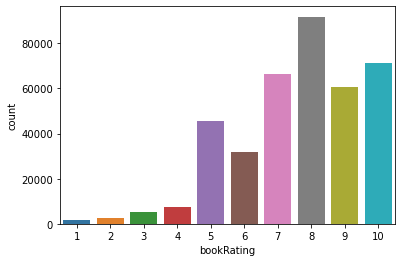

In [51]:
# Plot count of explicit bookRating values
sns.countplot(data=ratings_explicit , x='bookRating')
plt.show()

It seems that higher ratings are more common among users and rating 8 has been rated highest number of times

In [52]:
users_exp_ratings = users[users.userID.isin(ratings_explicit.userID)]
users_imp_ratings = users[users.userID.isin(ratings_implicit.userID)]

print(f'# users: {users.shape[0]}')
print(f'# users who explictly gave ratings: {users_exp_ratings.shape[0]}')
print(f'# users whose implict behavior was tracked: {users_imp_ratings.shape[0]}')

# users: 278858
# users who explictly gave ratings: 68091
# users whose implict behavior was tracked: 52451


### Simple Popularity Based Recommendation System

In [53]:
# Let's build a simple popularity based recommendation system based on count of user ratings for different books
ratings_count = pd.DataFrame(ratings_explicit.groupby(['ISBN'])['bookRating'].sum())
top10 = ratings_count.sort_values('bookRating', ascending = False).head(10)
top10

,bookRating
ISBN,
0316666343,5787
0385504209,4108
0312195516,3134
059035342X,2798
0142001740,2595
0971880107,2551
0060928336,2524
0446672211,2402
0452282152,2219


In [54]:
print("Top 10 books by user ratings:")
top10.merge(books, left_index = True, right_on = 'ISBN')

Top 10 books by user ratings:


,bookRating,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
408,5787,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown"
748,4108,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday
522,3134,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA
2143,2798,059035342X,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),J. K. Rowling,1999,Arthur A. Levine Books
356,2595,0142001740,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books
26,2551,0971880107,Wild Animus,Rich Shapero,2004,Too Far
1105,2524,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial
706,2402,0446672211,Where the Heart Is (Oprah's Book Club (Paperback)),Billie Letts,1998,Warner Books
231,2219,0452282152,Girl with a Pearl Earring,Tracy Chevalier,2001,Plume Books
118,2179,0671027360,Angels &amp; Demons,Dan Brown,2001,Pocket Star


### Collaborative Filtering Based Recommendation System

In [55]:
# To reduce required computing power, we need to reduce the dataset size.
# Let's only consider users who have rated at least 100 books and books which have at least 100 ratings
print(f'# explicit ratings before filtering: {ratings_explicit.shape[0]}')
counts1 = ratings_explicit['userID'].value_counts()
ratings_explicit = ratings_explicit[ratings_explicit['userID'].isin(counts1[counts1 >= 100].index)]

counts2 = ratings_explicit['bookRating'].value_counts()
ratings_explicit = ratings_explicit[ratings_explicit['bookRating'].isin(counts2[counts2 >= 100].index)]
print(f'# explicit ratings after filtering: {ratings_explicit.shape[0]}')

# explicit ratings before filtering: 383841
# explicit ratings after filtering: 103271


In [56]:
# Generate ratings matrix from explicit ratings
ratings_matrix = ratings_explicit.pivot(index='userID', columns='ISBN', values='bookRating')
print(f'# users who gave explicit ratings : {ratings_matrix.shape[0]}')
print(f'# books with explicit ratings : {ratings_matrix.shape[1]}')

# Review explicit ratings matrix
ratings_matrix.head()

# users who gave explicit ratings : 449
# books with explicit ratings : 66574


ISBN,0000913154,0001046438,000104687X,0001047213,0001047973,000104799X,0001048082,0001053736,0001053744,0001055607,...,B000092Q0A,B00009EF82,B00009NDAN,B0000DYXID,B0000T6KHI,B0000VZEJQ,B0000X8HIE,B00013AX9E,B0001I1KOG,B000234N3A
userID,,,,,,,,,,,,,,,,,,,,,
2033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Notice that most of the values are NaN (undefined) implying absence of ratings

In [57]:
# Since NaNs cannot be handled by training algorithms, replace them with 0, which indicates absence of ratings
ratings_matrix.fillna(0, inplace = True)

# Reset data type
ratings_matrix = ratings_matrix.astype(np.int32)

# Review explicit ratings matrix
print(ratings_matrix.shape)
ratings_matrix.head(5)

(449, 66574)


ISBN,0000913154,0001046438,000104687X,0001047213,0001047973,000104799X,0001048082,0001053736,0001053744,0001055607,...,B000092Q0A,B00009EF82,B00009NDAN,B0000DYXID,B0000T6KHI,B0000VZEJQ,B0000X8HIE,B00013AX9E,B0001I1KOG,B000234N3A
userID,,,,,,,,,,,,,,,,,,,,,
2033,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2110,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2276,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4017,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4385,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
# Transpose explicit ratings matrix
ratings_matrix_tmp = ratings_matrix.transpose(copy=True)    # Same as ratings_matrix.T

# Review transposed explicit ratings matrix
print(ratings_matrix_tmp.shape)
ratings_matrix_tmp.head()

(66574, 449)


userID,2033,2110,2276,4017,4385,5582,6242,6251,6543,6575,...,269566,270713,271448,271705,273113,274061,274301,275970,277427,278418
ISBN,,,,,,,,,,,,,,,,,,,,,
0000913154,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0001046438,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000104687X,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0001047213,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0001047973,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
# Recheck the sparsity
sparsity=1.0-len(ratings_explicit)/float(users_exp_ratings.shape[0]*n_books)
print('Sparsity of ratings_explicit dataset is ' +  str(sparsity*100) + ' %')

Sparsity of ratings_explicit dataset is 99.99944108670562 %


### Set global variables

In [60]:
global k, metric, rec_type, min_num_calc_ratings, rating_thresh
k=10
metric='cosine'
rec_type='user-based'
min_num_calc_ratings=10
rating_thresh=2

### User-based Recommender

In [61]:
# Create function that finds k similar users given the user_id and ratings matrix 
# These similarities are the same we would have obtained via using pairwise_distances
def findksimilarusers(user_id, ratings, metric=metric, k=k, verbose=False):
    similarities=[]
    indices=[]
    model_knn = NearestNeighbors(metric = metric, algorithm = 'brute') 
    model_knn.fit(ratings)
    loc = ratings.index.get_loc(user_id)
    if verbose:
        print(metric)
        print(loc)
        print(ratings.iloc[loc, :].values)
        print(ratings.iloc[loc, :].values.reshape(1, -1))

    distances, indices = model_knn.kneighbors(ratings.iloc[loc, :].values.reshape(1, -1), n_neighbors = k+1)
    similarities = 1-distances.flatten()
    if verbose:
        print(distances)
        print(distances.flatten())
        print(similarities)
        print()
            
    return similarities,indices

In [62]:
# Create function that predicts rating for specified user-item combination based on user-based approach
def predict_userbased(user_id, item_id, ratings, metric=metric, k=k, verbose=False):
    prediction=0
    user_loc = ratings.index.get_loc(user_id)
    item_loc = ratings.columns.get_loc(item_id)
    similarities, indices=findksimilarusers(user_id, ratings, metric, k, verbose)
    mean_rating = ratings.iloc[user_loc,:].mean()
    sum_wt = np.sum(similarities)-1
    product=1
    wtd_sum = 0 
    
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i] == user_loc:
            continue;
        else: 
            ratings_diff = ratings.iloc[indices.flatten()[i],item_loc]-np.mean(ratings.iloc[indices.flatten()[i],:])
            product = ratings_diff * (similarities[i])
            wtd_sum = wtd_sum + product    
    prediction = int(round(mean_rating + (wtd_sum/sum_wt)))

    # In case of very sparse datasets, using correlation metric for collaborative based approach may
    #  result in negative ratings or ratings above 10, so we need to handle them below
    if prediction <= 0:
        prediction = 1   
    elif prediction >10:
        prediction = 10
    
    if verbose:
        print('Predicted rating for user {0} -> item {1}: {2}'.format(user_id,item_id,prediction))

    return prediction

In [63]:
# 0316666343
# 0001056107
predict_userbased(11676, '0316666343', ratings_matrix, verbose=True);

cosine
17
[0 0 0 ... 0 0 0]
[[0 0 0 ... 0 0 0]]
[[8.88178420e-16 9.19591812e-01 9.21354544e-01 9.29992765e-01
  9.33793492e-01 9.36651741e-01 9.38286275e-01 9.42284204e-01
  9.43064771e-01 9.43201598e-01 9.44481271e-01]]
[8.88178420e-16 9.19591812e-01 9.21354544e-01 9.29992765e-01
 9.33793492e-01 9.36651741e-01 9.38286275e-01 9.42284204e-01
 9.43064771e-01 9.43201598e-01 9.44481271e-01]
[1.         0.08040819 0.07864546 0.07000724 0.06620651 0.06334826
 0.06171372 0.0577158  0.05693523 0.0567984  0.05551873]

Predicted rating for user 11676 -> item 0316666343: 3


In [64]:
# 0316666343
# 0001056107
predict_userbased(11676, '0316666343', ratings_matrix, metric='correlation', verbose=True);

correlation
17
[0 0 0 ... 0 0 0]
[[0 0 0 ... 0 0 0]]
[[0.         0.93954613 0.9477423  0.95187654 0.9547398  0.95527788
  0.95661001 0.95682624 0.95839776 0.95884607 0.96023218]]
[0.         0.93954613 0.9477423  0.95187654 0.9547398  0.95527788
 0.95661001 0.95682624 0.95839776 0.95884607 0.96023218]
[1.         0.06045387 0.0522577  0.04812346 0.0452602  0.04472212
 0.04338999 0.04317376 0.04160224 0.04115393 0.03976782]

Predicted rating for user 11676 -> item 0316666343: 3


### Item-based Recommender

In [65]:
# Create function that finds k similar items given the item_id and ratings matrix
def findksimilaritems(item_id, ratings, metric=metric, k=k, verbose=False):
    ratings=ratings.T     # Transpose matrix
    similarities=[]
    indices=[]
    model_knn = NearestNeighbors(metric = metric, algorithm = 'brute')
    model_knn.fit(ratings)
    loc = ratings.index.get_loc(item_id)
    if verbose:
        print(metric)
        print(loc)
        print(ratings.iloc[loc, :].values)
        print(ratings.iloc[loc, :].values.reshape(1, -1))
    
    distances, indices = model_knn.kneighbors(ratings.iloc[loc, :].values.reshape(1, -1), n_neighbors = k+1)
    similarities = 1-distances.flatten()
    if verbose:
        print(distances)
        print(distances.flatten())
        print(similarities)
        print()

    return similarities,indices

In [66]:
# Create function that predicts the rating for specified user-item combination based on item-based approach
def predict_itembased(user_id, item_id, ratings, metric=metric, k=k, verbose=False):
    prediction = wtd_sum = 0
    user_loc = ratings.index.get_loc(user_id)
    item_loc = ratings.columns.get_loc(item_id)
    similarities, indices=findksimilaritems(item_id, ratings, metric, k, verbose)
    sum_wt = np.sum(similarities)-1
    product=1
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i] == item_loc:
            continue;
        else:
            product = ratings.iloc[user_loc,indices.flatten()[i]] * (similarities[i])
            wtd_sum = wtd_sum + product                              
    prediction = int(round(wtd_sum/sum_wt))
    
    # In case of very sparse datasets, using correlation metric for collaborative based approach may
    #  result in negative ratings or ratings above 10, so we need to handle them below
    if prediction <= 0:
        prediction = 1   
    elif prediction >10:
        prediction = 10

    if verbose:
        print('Predicted rating for user {0} -> item {1}: {2}'.format(user_id,item_id,prediction))
    
    return prediction

In [67]:
# 0316666343
# 0001056107
prediction = predict_itembased(11676, '0316666343', ratings_matrix, verbose=True)

cosine
10345
[ 0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  8  5  0  0  0  0  0  0
  0  0  0  0 10  0  0  0  0  7  0  0  0  0  0  0  0  0  0 10  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  6  0  0  0  9  0  0  0  0  0  0  0  6  0
  0  0  0  0  0  6  0  0  0  0  0  0  0  0  9  0  0  0  0  0  0  0  0  8
  0  8  0  0  0  0  0  0  0  8  0  0  7  0  0  0  0  0  0  0  0  9 10  0
  0  0  0 10  0  0  0  9  0  0  0  0  0  0  8  0  0  0  0  0  0  0  8  0
  0  0  0  0  0  0  0  0  0  0  9  0  0  0  0  9  9  0  0  0  0  0  0  0
  0  0  0  0  0  0  9  8  0  0  0  0  0  0  0  0  0  0  9  9  9  5  0  0
  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  8  0
  0  0  0  0  0  0  0  0  0 10  0 10  0 10  0 10  9  0  0  0  0  0  0  0
  8  0  0  0  0  0  0  0  0  0  0  8  0  7  0  0  0  0  0  0  0  0  9  0
  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  7  8  0  0
  0  0  0  0  0  0  7  0  0  0  0  0  0  0  0  0  0  0  9  0  0  0  0  0
  0  0  0  0  0  8  8  0  0  0  0  0  

In [68]:
# 0316666343
# 0001056107
prediction = predict_itembased(11676, '0316666343', ratings_matrix, metric='correlation', verbose=True)

correlation
10345
[ 0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  8  5  0  0  0  0  0  0
  0  0  0  0 10  0  0  0  0  7  0  0  0  0  0  0  0  0  0 10  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  6  0  0  0  9  0  0  0  0  0  0  0  6  0
  0  0  0  0  0  6  0  0  0  0  0  0  0  0  9  0  0  0  0  0  0  0  0  8
  0  8  0  0  0  0  0  0  0  8  0  0  7  0  0  0  0  0  0  0  0  9 10  0
  0  0  0 10  0  0  0  9  0  0  0  0  0  0  8  0  0  0  0  0  0  0  8  0
  0  0  0  0  0  0  0  0  0  0  9  0  0  0  0  9  9  0  0  0  0  0  0  0
  0  0  0  0  0  0  9  8  0  0  0  0  0  0  0  0  0  0  9  9  9  5  0  0
  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  8  0
  0  0  0  0  0  0  0  0  0 10  0 10  0 10  0 10  9  0  0  0  0  0  0  0
  8  0  0  0  0  0  0  0  0  0  0  8  0  7  0  0  0  0  0  0  0  0  9  0
  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  7  8  0  0
  0  0  0  0  0  0  7  0  0  0  0  0  0  0  0  0  0  0  9  0  0  0  0  0
  0  0  0  0  0  8  8  0  0  0  0

### Full Recommendation System

In [69]:
# Create function that utilizes above functions to recommend items for item/user based approach
#  and cosine/correlation similarity 
# Recommendations are made if the predicted rating for an item is >= to 7,and the items have not been rated already
def recommendItem(user_id, ratings, metric=metric, rec_type=rec_type, \
                  min_num_calc_ratings=min_num_calc_ratings, rating_thresh=rating_thresh):    
    if (user_id not in ratings.index.values) or type(user_id) is not int:
        print("User id should be a valid integer from this list :\n\n {} ". \
              format(re.sub('[\[\]]', '', np.array_str(ratings_matrix.index.values))))
    else:    
        prediction = []            
        print('Generating {0} recommendations using {1} similarity'.format(rec_type, metric))
        print('Please be patient, this will take a few minutes ...\n')
        x=y=z=0
        if (rec_type == 'item-based'):
            for i in range(ratings.shape[1]):
                x+=1
                if (ratings[str(ratings.columns[i])][user_id] !=0): # item has not been rated by this user
                    y+=1
                    r = predict_itembased(user_id, str(ratings.columns[i]), ratings, metric)
#                    print("x={}, y={}, z={}, r={}".format(x,y,z,r))
                    if (r >= rating_thresh):
                        z+=1
                        prediction.append(r) # add to list of recommended items
                        if (z >= (min_num_calc_ratings*5)):
                            break
                    else:
                        prediction.append(-1) # rating does not meet threshold, so don't recommend it
                else:                    
                    prediction.append(-1) # item has already been rated by this user, so don't recommend it
        else:
            for i in range(ratings.shape[1]):
                x+=1
                if (ratings[str(ratings.columns[i])][user_id] !=0): # item has not been rated by this user
                    y+=1
                    r = predict_userbased(user_id, str(ratings.columns[i]), ratings, metric)
#                    print("x={}, y={}, z={}, r={}".format(x,y,z,r))
                    if (r >= rating_thresh):
                        z+=1
                        prediction.append(r) # add to list of recommended items
                        if (z >= min_num_calc_ratings):
                            break
                    else:
                        prediction.append(-1) # rating does not meet threshold, so don't recommend it
                else:                    
                    prediction.append(-1) # item has already been rated by this user, so don't recommend it
        prediction = pd.Series(prediction)
        prediction = prediction.sort_values(ascending=False)
        recommended = prediction[:10]
        print("Recommended books")
        for i in range(len(recommended)):
            print("{0}. [{1}] - {2}".format(i+1, recommended.index[i], books.bookTitle[recommended.index[i]]))
        print()

In [70]:
# Check with invalid user
recommendItem(999999, ratings_matrix)

User id should be a valid integer from this list :

   2033   2110   2276   4017   4385   5582   6242   6251   6543   6575
   7286   7346   8067   8245   8681   8890  10560  11676  11993  12538
  12824  12982  13552  13850  14422  15408  15418  16634  16795  16966
  17950  19085  21014  23768  23872  23902  25409  25601  25981  26535
  26544  26583  28591  28634  29259  30276  30511  30711  30735  30810
  31315  31556  31826  32773  33145  35433  35836  35857  35859  36299
  36554  36606  36609  36836  36907  37644  37712  37950  38023  38273
  38281  39281  39467  40889  40943  43246  43910  46398  47316  48025
  48494  49144  49889  51883  52199  52350  52584  52614  52917  53220
  55187  55490  55492  56271  56399  56447  56554  56959  59172  60244
  60337  60707  63714  63956  65258  66942  67840  68555  69078  69389
  69697  70415  70594  70666  72352  73681  75591  75819  76151  76223
  76499  76626  78553  78783  78834  78973  79441  81492  81560  83287
  83637  83671  85526  85

In [71]:
%%time

# Get user-based recommendations using cosine similarity
recommendItem(11676, ratings_matrix, metric='cosine', rec_type='user-based')

Generating user-based recommendations using cosine similarity
Please be patient, this will take a few minutes ...

Recommended books
1. [1535] - Somebody to Love? : A Rock-and-Roll Memoir
2. [1342] - The Distance Between
3. [2049] - Year's Best Fantasy and Horror: Sixteenth Edition
4. [1584] - In My Father's House (Point)
5. [1898] - Leading Corporate Citizens
6. [921] - Die SÃ?Â¤ulen der Erde. Roman.
7. [685] - Stately Pursuits
8. [1201] - Trading Places
9. [1852] - Irish Mist: A Nuala Anne McGrail Novel (Nuala Anne McGrail Novels (Paperback))
10. [643] - A Fountain Filled With Blood (A Rev. Clare Ferguson Mystery)

CPU times: user 3min 54s, sys: 38.3 s, total: 4min 32s
Wall time: 3min 2s


In [72]:
%%time

# Get user-based recommendations using correlation similarity
recommendItem(11676, ratings_matrix, metric='correlation', rec_type='user-based')

Generating user-based recommendations using correlation similarity
Please be patient, this will take a few minutes ...

Recommended books
1. [921] - Die SÃ?Â¤ulen der Erde. Roman.
2. [2231] - The Selfish Gene
3. [1201] - Trading Places
4. [1898] - Leading Corporate Citizens
5. [2049] - Year's Best Fantasy and Horror: Sixteenth Edition
6. [994] - The Stars Shine Down
7. [1584] - In My Father's House (Point)
8. [643] - A Fountain Filled With Blood (A Rev. Clare Ferguson Mystery)
9. [1535] - Somebody to Love? : A Rock-and-Roll Memoir
10. [1124] - The Best Thing I Ever Did for My Marriage : 50 Real Life Stories

CPU times: user 3min 30s, sys: 59.7 s, total: 4min 30s
Wall time: 4min 40s


In [73]:
%%time

# Get item-based recommendations using cosine similarity
recommendItem(11676, ratings_matrix, metric='cosine', rec_type='item-based')

Generating item-based recommendations using cosine similarity
Please be patient, this will take a few minutes ...

Recommended books
1. [293] - The Forsyte Saga : The Man of Property and In Chancery
2. [281] - Confessions of a Shopaholic
3. [138] - Twenty Minute Retreats: Revive Your Spirits in Just Minutes a Day (A Pan Self-discovery Title)
4. [615] - The Hellfire Club
5. [98] - Pasquale's Nose: Idle Days in an Italian Town
6. [111] - The Touch of Your Shadow, the Whisper of Your Name (Babylon 5, Book 5)
7. [109] - Relics (Star Trek: The Next Generation)
8. [103] - McDonald's: Behind the Arches
9. [101] - Rich Dad, Poor Dad: What the Rich Teach Their Kids About Money--That the Poor and Middle Class Do Not!
10. [93] - El Senor De Los Anillos: El Retorno Del Rey (Tolkien, J. R. R. Lord of the Rings. 3.)

CPU times: user 44.1 s, sys: 8.79 s, total: 52.9 s
Wall time: 23.8 s


In [74]:
%%time

# Get item-based recommendations using correlation similarity
recommendItem(11676, ratings_matrix, metric='correlation', rec_type='item-based')

Generating item-based recommendations using correlation similarity
Please be patient, this will take a few minutes ...

Recommended books
1. [44] - Icebound
2. [281] - Confessions of a Shopaholic
3. [93] - El Senor De Los Anillos: El Retorno Del Rey (Tolkien, J. R. R. Lord of the Rings. 3.)
4. [98] - Pasquale's Nose: Idle Days in an Italian Town
5. [111] - The Touch of Your Shadow, the Whisper of Your Name (Babylon 5, Book 5)
6. [138] - Twenty Minute Retreats: Revive Your Spirits in Just Minutes a Day (A Pan Self-discovery Title)
7. [142] - The Soulbane Stratagem
8. [149] - Scarlet Letter
9. [615] - The Hellfire Club
10. [51] - Left Behind: A Novel of the Earth's Last Days (Left Behind #1)

CPU times: user 14 s, sys: 7.33 s, total: 21.3 s
Wall time: 22.8 s
